# **1. Import Dependencies**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import dijkstra
import networkx as nx

In [ ]:
from matplotlib.collections import LineCollection

# **2. Testing Grounds**

In [ ]:
CANVAS_SIZE = 1000
NUM_STATIONS = 25
ISLAND_PENALTY = 5000

In [ ]:
CANVAS = tf.fill((CANVAS_SIZE, CANVAS_SIZE), 0).numpy()

In [ ]:
STATION_IDXS = tf.random.uniform(
    shape=(NUM_STATIONS, 2),
    minval=0,
    maxval=CANVAS_SIZE-1,
    dtype=tf.int32
).numpy()

STATION_IDXS

array([[911, 894],
       [310, 201],
       [637, 957],
       [849, 262],
       [746, 862],
       [863, 446],
       [289, 812],
       [206, 355],
       [942,   2],
       [620, 987],
       [345, 778],
       [565, 553],
       [ 20, 107],
       [577,  75],
       [787, 935],
       [951, 428],
       [527, 405],
       [970, 598],
       [963, 233],
       [393, 444],
       [488, 430],
       [893, 948],
       [475, 475],
       [ 65, 715],
       [277,  12]], dtype=int32)

In [ ]:
STATION_SIZES = tf.random.normal(
    shape=(NUM_STATIONS,),
    mean=500.0,
    stddev=200.0,
    dtype=tf.float32
).numpy()

STATION_SIZES

array([ 133.33939,  500.44568,  512.8387 ,  250.95828,  219.75928,
        132.32166,  344.83325,  570.2913 ,  793.46655, 1045.9292 ,
        416.49133,  473.4914 ,  708.82275,  404.0854 ,  443.1251 ,
        485.59528,  808.2777 ,  700.215  ,  632.5094 ,  472.77197,
        311.11426,  828.4941 , 1009.85815,  513.47015,  398.93488],
      dtype=float32)

In [ ]:
DISTANCES = np.zeros((NUM_STATIONS, NUM_STATIONS))

for i in range(NUM_STATIONS):
  for j in range(NUM_STATIONS):
    DISTANCES[i,j] = np.linalg.norm(STATION_IDXS[i]-STATION_IDXS[j])

DISTANCES

array([[   0.        ,  917.30583777,  281.14942646,  635.03385737,
         168.07438829,  450.56409089,  627.38186139,  887.43788515,
         892.53851458,  305.49959083,  577.76465797,  485.79522435,
        1188.8019179 ,  884.48685688,  130.60245021,  467.71358757,
         621.75316646,  301.82279569,  663.04223093,  686.16616063,
         627.87339488,   56.92099788,  604.69579129,  864.72943745,
        1086.22281324],
       [ 917.30583777,    0.        ,  823.68986882,  542.44078018,
         791.8440503 ,  604.84212816,  611.36077728,  185.82787735,
         662.58961658,  844.92366519,  578.06055046,  434.65963696,
         304.85406345,  295.23719278,  875.37706161,  680.0073529 ,
         297.8338463 ,  770.20062321,  653.78360334,  256.78395589,
         290.04310025,  947.57479916,  319.84527509,  569.40407445,
         191.85932346],
       [ 281.14942646,  823.68986882,    0.        ,  726.6147535 ,
         144.58907289,  558.74591721,  377.        ,  740.38165834,


In [ ]:
DEMAND = tf.random.uniform(
    shape=(NUM_STATIONS, NUM_STATIONS),
    minval=0,
    maxval=1
).numpy()

# Scale based on inverse root of distance
for i in range(NUM_STATIONS):
  for j in range(NUM_STATIONS):
    if i != j:
      DEMAND[i,j] *= (1 / (DISTANCES[i,j]**0.5))
    else:
      DEMAND[i,j] = 0

# Standardize
for col in range(NUM_STATIONS):
  colSum = np.sum(DEMAND[:, col])
  for row in range(NUM_STATIONS):
    DEMAND[row, col] = DEMAND[row, col] / colSum

DEMAND

array([[0.00000000e+00, 2.49940827e-02, 2.97264811e-02, 1.54002989e-02,
        6.32886216e-02, 4.42204215e-02, 5.51035777e-02, 1.35640204e-02,
        5.22266664e-02, 8.32733419e-03, 2.72684190e-02, 5.63842021e-02,
        5.20208552e-02, 6.91298675e-03, 1.04715906e-01, 8.59135464e-02,
        2.93198489e-02, 3.30605619e-02, 4.20367606e-02, 1.03659993e-02,
        5.22433082e-03, 1.41187102e-01, 7.97009375e-03, 4.19375449e-02,
        1.34975594e-02],
       [2.33290158e-02, 0.00000000e+00, 5.47394045e-02, 7.82174524e-03,
        3.68374027e-02, 5.87428920e-02, 5.14891632e-02, 6.63138330e-02,
        4.55868989e-02, 4.95168790e-02, 2.50300542e-02, 1.51126748e-02,
        3.45222987e-02, 1.87190678e-02, 2.55939476e-02, 1.71810423e-03,
        5.84275462e-02, 4.33225185e-03, 2.89268754e-02, 3.23632620e-02,
        4.69553247e-02, 4.73401211e-02, 5.70772849e-02, 1.07398795e-04,
        2.58528963e-02],
       [7.31393099e-02, 6.59729168e-03, 0.00000000e+00, 3.36292759e-02,
        1.0074

In [ ]:
TRIPS = np.array([[int(round(STATION_SIZES[start] * DEMAND[end, start])) for start in range(NUM_STATIONS)] for end in range(NUM_STATIONS)])

TRIPS

array([[  0,  13,  15,   4,  14,   6,  19,   8,  41,   9,  11,  27,  37,
          3,  46,  42,  24,  23,  27,   5,   2, 117,   8,  22,   5],
       [  3,   0,  28,   2,   8,   8,  18,  38,  36,  52,  10,   7,  24,
          8,  11,   1,  47,   3,  18,  15,  15,  39,  58,   0,  10],
       [ 10,   3,   0,   8,  22,   1,   6,  31,  45, 137,  51,  27,  16,
         20,  27,  36,  18,   6,  23,  27,  15,  13,  37,  37,  12],
       [  5,  19,  20,   0,  11,   4,   7,  32,  50,  45,   3,   9,   3,
         19,   2,  51,  33,  19,  15,  19,  16,  46,  50,  36,  10],
       [ 11,   4,   8,  18,   0,   8,   5,   8,   5,  43,  18,  35,  32,
         11,  52,  18,  30,  51,   9,  30,   7,  58,  13,  19,  11],
       [  2,  20,  15,  25,  12,   0,  18,  10,  43,  40,  13,  39,  33,
         25,   6,   3,  40,  91,   4,   6,   2,  19,  24,   5,  32],
       [  3,  22,  20,   8,   8,   7,   0,  11,  48,  22,  27,  32,  40,
         18,  24,   9,  21,  27,  31,  24,  13,  45,  41,   3,  12],
      

In [ ]:
FLOW = np.zeros((NUM_STATIONS, NUM_STATIONS), dtype=np.int32)

FLOW = TRIPS + TRIPS.T

for i in range(NUM_STATIONS):
  FLOW[i, i] = 0

FLOW

array([[  0,  16,  25,   9,  25,   8,  22,  16,  45,  12,  12,  35,  38,
          9,  52,  44,  28,  38,  28,   6,   3, 128,  18,  31,  13],
       [ 16,   0,  31,  21,  12,  28,  40,  51,  69,  75,  12,  29,  57,
         52,  30,  18,  83,  14,  44,  16,  25,  63,  77,  36,  60],
       [ 25,  31,   0,  28,  30,  16,  26,  35,  49, 216,  53,  46,  35,
         38,  78,  75,  52,  35,  32,  49,  30,  16,  74,  38,  34],
       [  9,  21,  28,   0,  29,  29,  15,  37,  62,  47,   7,  26,   5,
         37,  12,  67,  47,  40,  19,  39,  23,  62,  57,  38,  21],
       [ 25,  12,  30,  29,   0,  20,  13,  12,   6,  69,  20,  40,  39,
         23,  57,  27,  38,  54,  22,  41,  12,  64,  26,  26,  15],
       [  8,  28,  16,  29,  20,   0,  25,  12,  52,  46,  15,  46,  34,
         35,   7,  16,  45,  98,  17,  12,  13,  22,  24,   7,  33],
       [ 22,  40,  26,  15,  13,  25,   0,  36,  56,  23,  86,  58,  41,
         25,  38,  26,  36,  35,  47,  34,  14,  66,  46,  34,  20],
      

In [ ]:
FULL_TRACK = 0
for i in range(NUM_STATIONS):
  for j in range(i, NUM_STATIONS):
    FULL_TRACK += DISTANCES[i,j]

FULL_TRACK

167333.2782569403

In [ ]:
"""LINES = np.round(0.7 * np.random.rand(NUM_STATIONS, NUM_STATIONS))

LINES"""

'LINES = np.round(0.7 * np.random.rand(NUM_STATIONS, NUM_STATIONS))\n\nLINES'

In [ ]:
LINES = np.ones((NUM_STATIONS, NUM_STATIONS))

LINES

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

In [ ]:
def plot_system(CANVAS, LINES, draw_lines=True):
  # Draw canvas
  plt.imshow(CANVAS, cmap='Greys')

  # Draw flow/demand between stations
  demand_lines = []
  for i in range(NUM_STATIONS):
      for j in range(i + 1, NUM_STATIONS):
          demand_lines.append([(STATION_IDXS[i, 0], STATION_IDXS[i, 1]), (STATION_IDXS[j, 0], STATION_IDXS[j, 1])])
  lc_stations = LineCollection(demand_lines, alpha=0.3, linestyle='-', linewidths=TRIPS.flatten()/20)
  plt.gca().add_collection(lc_stations)

  # Draw metro lines between stations
  if draw_lines:
    station_lines = []
    for i in range(NUM_STATIONS):
        for j in range(NUM_STATIONS):
            if LINES[i,j] == 1.0:
                station_lines.append([(STATION_IDXS[i, 0], STATION_IDXS[i, 1]), (STATION_IDXS[j, 0], STATION_IDXS[j, 1])])
    lc_stations = LineCollection(station_lines, alpha=1, color='black', linestyle='-', linewidths=1.5)
    plt.gca().add_collection(lc_stations)

  # Draw stations
  plt.scatter(STATION_IDXS[:,0], STATION_IDXS[:,1], s=STATION_SIZES/2, zorder=4)

  # Add station indices
  for i, (x, y, size) in enumerate(zip(STATION_IDXS[:, 0], STATION_IDXS[:, 1], STATION_SIZES)):
      fontsize = max(size**.7 * 0.1, 5)
      plt.annotate(str(i), (x, y), ha='center', va='center', size=fontsize, color='white', fontweight='bold', zorder=5)

  # Labels
  plt.title('MAP OF AREA')
  plt.xlabel('West/East')
  plt.ylabel('South/North')

  plt.show()

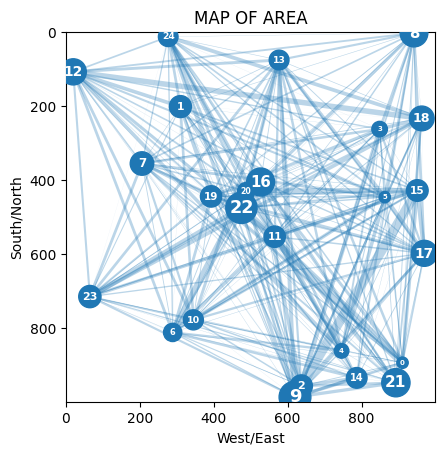

In [ ]:
plot_system(CANVAS, LINES, draw_lines=False)

In [ ]:
def find_shortest_path(adjacency_matrix, weight_matrix, source_node, target_node):
    try:
        # Create a directed graph from the matrices
        G = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

        # Add weights to the edges
        for i in range(G.number_of_nodes()):
            for j in range(G.number_of_nodes()):
                if G.has_edge(i, j):
                    G[i][j]['weight'] = weight_matrix[i, j]

        # Find the shortest path from source to target
        shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')

        # Calculate the sum of edge weights on the shortest path
        total_weight = sum(G[shortest_path[i]][shortest_path[i + 1]]['weight'] for i in range(len(shortest_path) - 1))

        return shortest_path, total_weight

    except nx.NetworkXNoPath:
        # Return -1 when there is no path between the nodes
        return -1, -1

In [ ]:
def get_min_dist(LINES, DISTANCES):
  MIN_DIST = np.zeros((NUM_STATIONS, NUM_STATIONS))

  for i in range(NUM_STATIONS):
    for j in range(NUM_STATIONS):
      shortest_path, total_weight = find_shortest_path(LINES, DISTANCES, i, j)
      MIN_DIST[i,j] = total_weight

  return MIN_DIST

In [ ]:
MIN_DIST = get_min_dist(LINES, DISTANCES)

MIN_DIST

array([[   0.        ,  917.30583777,  281.14942646,  635.03385737,
         168.07438829,  450.56409089,  627.38186139,  887.43788515,
         892.53851458,  305.49959083,  577.76465797,  485.79522435,
        1188.8019179 ,  884.48685688,  130.60245021,  467.71358757,
         621.75316646,  301.82279569,  663.04223093,  686.16616063,
         627.87339488,   56.92099788,  604.69579129,  864.72943745,
        1086.22281324],
       [ 917.30583777,    0.        ,  823.68986882,  542.44078018,
         791.8440503 ,  604.84212816,  611.36077728,  185.82787735,
         662.58961658,  844.92366519,  578.06055046,  434.65963696,
         304.85406345,  295.23719278,  875.37706161,  680.0073529 ,
         297.8338463 ,  770.20062321,  653.78360334,  256.78395589,
         290.04310025,  947.57479916,  319.84527509,  569.40407445,
         191.85932346],
       [ 281.14942646,  823.68986882,    0.        ,  726.6147535 ,
         144.58907289,  558.74591721,  377.        ,  740.38165834,


In [ ]:
def get_flow_score(LINES, DISTANCES):
    MIN_DIST = get_min_dist(LINES, DISTANCES)

    # Vectorized computation of total distance
    total_dist = np.sum(np.where(MIN_DIST != -1, MIN_DIST * TRIPS, ISLAND_PENALTY * TRIPS))

    return total_dist / np.sum(TRIPS)

In [ ]:
F = get_flow_score(LINES, DISTANCES)

F

509.96040772055136

In [ ]:
BEST_SCORE = F

# **3. Evolution**

## **3.1 Initialization**

In [ ]:
CANVAS_SIZE = 1000
NUM_STATIONS = 25
ISLAND_PENALTY = 20000
TRACK_LIMIT = 5000

NUM_GENERATIONS = 100
POP_SIZE = 100
CROSSOVER_RATE = 0.2
MUTATION_RATE = 0.05

PARENT_SHARE = 0.4
MUTATED_SHARE = 0.4
ELITE_SHARE = 0.2

NUM_PARENTS = int(PARENT_SHARE * POP_SIZE)
NUM_MUTANTS = int(MUTATED_SHARE * POP_SIZE)
NUM_ELITES = int(ELITE_SHARE * POP_SIZE)

TRACK_GEN = 0.55
GEN_PROB = 7
NUM_TO_ELIM = 10
OFF_RATIO = 0.5

In [ ]:
# Initialize the lines probabilistically based on distance
def initialize_lines_probabilistic(NUM_STATIONS, DISTANCES):
    lines = np.zeros((NUM_STATIONS, NUM_STATIONS))
    for i in range(NUM_STATIONS):
        for j in range(i + 1, NUM_STATIONS):
            # Probability of connection decreases with distance
            prob = np.exp(-DISTANCES[i, j] / CANVAS_SIZE * GEN_PROB)
            if np.random.rand() < prob:
                lines[i, j] = 1
                lines[j, i] = 1
    return lines

In [ ]:
LINES_POP = np.array([initialize_lines_probabilistic(NUM_STATIONS, DISTANCES) for _ in range(POP_SIZE)])

In [ ]:
#LINES_POP = np.round(TRACK_GEN * np.random.rand(POP_SIZE, NUM_STATIONS, NUM_STATIONS))

In [ ]:
LINES_POP[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
# check avg track length
track_lens = np.zeros((POP_SIZE))
for pop in range(POP_SIZE):
  track_len = 0
  track = LINES_POP[pop] * DISTANCES
  for i in range(NUM_STATIONS):
    for j in range(i+1, NUM_STATIONS):
      if track[i,j] > 0 or track[j,i] > 0:
        track_len += DISTANCES[i,j]
  track_lens[pop] = track_len

avg_len = np.sum(track_lens) / POP_SIZE

avg_len

5246.368085038245

In [ ]:
# shorten lines if too much track is used
tasks = np.ones((POP_SIZE))
while np.sum(tasks) != 0:
  for pop in range(POP_SIZE):
    track_len = 0
    track = LINES_POP[pop] * DISTANCES
    for i in range(NUM_STATIONS):
      for j in range(i+1, NUM_STATIONS):
        if track[i,j] > 0 or track[j,i] > 0:
          track_len += DISTANCES[i,j]
    if track_len > TRACK_LIMIT:
      LINES_POP[pop] = np.array([initialize_lines_probabilistic(NUM_STATIONS, DISTANCES)])
    else:
      tasks[pop] = 0

In [ ]:
# make sure all lines are within the track limit after shortening
for pop in range(POP_SIZE):
    track_len = 0
    track = LINES_POP[pop] * DISTANCES
    for i in range(NUM_STATIONS):
      for j in range(i+1, NUM_STATIONS):
        if track[i,j] > 0 or track[j,i] > 0:
          track_len += DISTANCES[i,j]
    print(track_len)

4870.095200916679
3683.2813232064686
4641.081368997227
4167.161761206516
4371.007412608725
3038.0287795481804
3676.8115948473474
3037.506272981021
4062.728516741458
4636.0373608056425
3041.2375114416304
3155.9777092246163
4614.024213487121
3469.6320351493005
4091.994634994521
4750.641339748254
4724.699978073803
4271.617539041258
4337.00209265475
4235.548794477058
4422.663865945976
4560.9793123493155
4415.843197077125
4433.547406541335
4842.016018775585
3993.9102074616094
4127.746124961859
2862.530231963658
4538.689248241942
4098.218966018062
2984.7033048992494
4152.772541693117
4588.96351507241
4289.688706308101
4489.428978294659
4909.6254934289755
4773.200571445285
4404.410325637461
4087.12797202258
3696.4709160846733
4943.635968243207
4309.126085395099
3267.408693180309
4214.274956399571
4745.591163765065
4548.922288374515
4627.727434560308
2611.2799204163844
3943.478836298836
4441.555400995579
4236.558341414656
3526.856803298607
3990.804118326215
4884.740325791395
4445.535183664801


## **3.2 Functions**

In [ ]:
def evaluate(LINES_POP):
    FLOW_SCORES = np.zeros((POP_SIZE))
    FITNESS_SCORES = np.zeros((POP_SIZE))
    best_track_len = float('inf')

    for pop in range(POP_SIZE):
      FLOW_SCORES[pop] = get_flow_score(LINES_POP[pop], DISTANCES)

      # Calculate track length for the current line
      track = LINES_POP[pop] * DISTANCES
      track_len = 0
      for i in range(NUM_STATIONS):
        for j in range(i+1, NUM_STATIONS):
          if track[i,j] > 0 or track[j,i] > 0:
            track_len += DISTANCES[i,j]
      FITNESS_SCORES[pop] = FLOW_SCORES[pop] + track_len
      if track_len < best_track_len:
        best_track_len = track_len

    best_idx = np.argmin(FITNESS_SCORES)
    best_fit_flow_score = FLOW_SCORES[best_idx]
    best_fit_score = FITNESS_SCORES[best_idx]
    best_line = LINES_POP[best_idx]
    avg_flow_score = np.average(FLOW_SCORES)
    avg_fit_score = np.average(FITNESS_SCORES)

    return best_idx, best_fit_flow_score, best_fit_score, best_track_len, best_line, avg_flow_score, avg_fit_score, FLOW_SCORES, FITNESS_SCORES

In [ ]:
def selection(FITNESS_SCORES):
    # Create shuffled indices
    shuffled_indices = np.random.permutation(len(FITNESS_SCORES))

    # Select parent indices
    parent_idxs = shuffled_indices[:NUM_PARENTS]

    # Select mutated indices
    mutated_idxs = shuffled_indices[NUM_PARENTS:NUM_PARENTS+NUM_MUTANTS]

    # Select elite indices
    elite_idxs = np.argsort(FITNESS_SCORES)[:NUM_ELITES]

    return parent_idxs, mutated_idxs, elite_idxs

In [ ]:
def crossover(parents):
  pairs = np.reshape(parents, (NUM_PARENTS // 2, 2, NUM_STATIONS, NUM_STATIONS))
  for pair_idx in range(np.shape(pairs)[0]):
    pair = pairs[pair_idx]
    child0 = pair[0, :, :]
    child1 = pair[1, :, :]
    # Slice along first axis
    for slice_idx in range(1, NUM_STATIONS):
      if np.random.rand() < CROSSOVER_RATE:
        child0 = np.concatenate((pair[0, :slice_idx, :], pair[1, slice_idx:, :]), axis=0)
        child1 = np.concatenate((pair[1, :slice_idx, :], pair[0, slice_idx:, :]), axis=0)

    # Slice along second axis
    for slice_idx in range(1, NUM_STATIONS):
      if np.random.rand() < CROSSOVER_RATE:
        temp0 = np.concatenate((child0[:, :slice_idx], pair[1, :, slice_idx:]), axis=1)
        temp1 = np.concatenate((child1[:, :slice_idx], pair[0, :, slice_idx:]), axis=1)
        # Update children
        child0 = temp0
        child1 = temp1
    temp = np.array((child0, child1))
    pairs[pair_idx] = temp
  pairs = np.reshape(pairs, (NUM_PARENTS, NUM_STATIONS, NUM_STATIONS))
  return pairs

In [ ]:
def mutation(mutants):
  for mutant_idx in range(NUM_MUTANTS):
    mutated = mutants[mutant_idx]
    # Mutate
    for i in range(NUM_STATIONS):
      for j in range(NUM_STATIONS):
        if np.random.rand() < MUTATION_RATE:
          if mutated[i, j] == 1:
            mutated[i, j] = 0
          else:
            mutated[i, j] = 1
    mutants[mutant_idx] = mutated
  return mutants

# **4. Results**

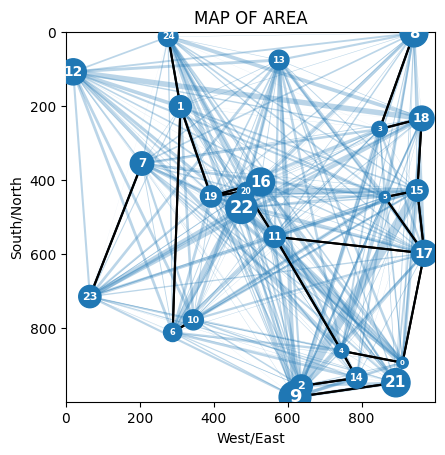

GENERATION #0
Average Fitness: 17469.45592701764
Average Flow Score: 13432.812165837237
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 1787.0862984744397
FULL TRACK: 167333.2782569403


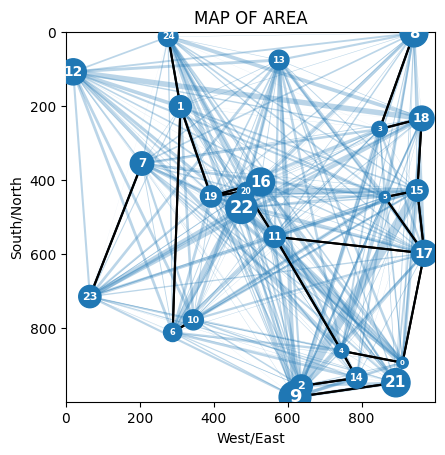

GENERATION #1
Average Fitness: 19545.48790835689
Average Flow Score: 8881.419844865992
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3037.506272981021
FULL TRACK: 167333.2782569403


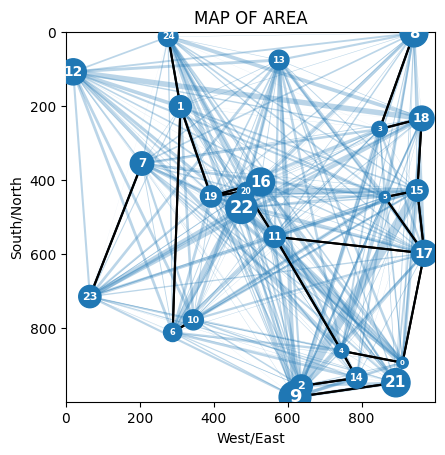

GENERATION #2
Average Fitness: 22649.000701265777
Average Flow Score: 6725.561102145385
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3267.408693180309
FULL TRACK: 167333.2782569403


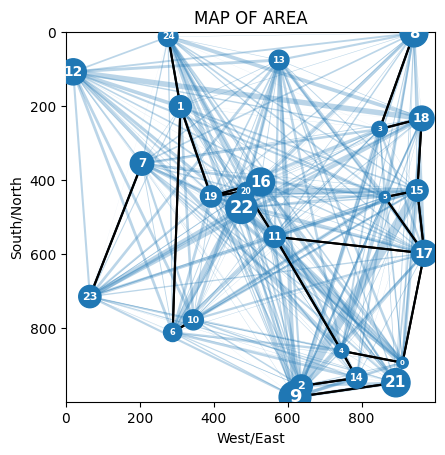

GENERATION #3
Average Fitness: 26063.010690044357
Average Flow Score: 5598.939375271947
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


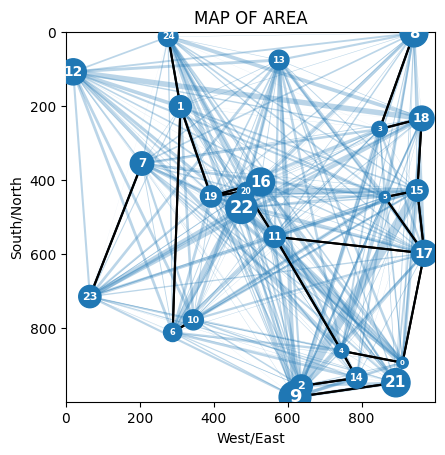

GENERATION #4
Average Fitness: 27656.15826199001
Average Flow Score: 5163.317499718814
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


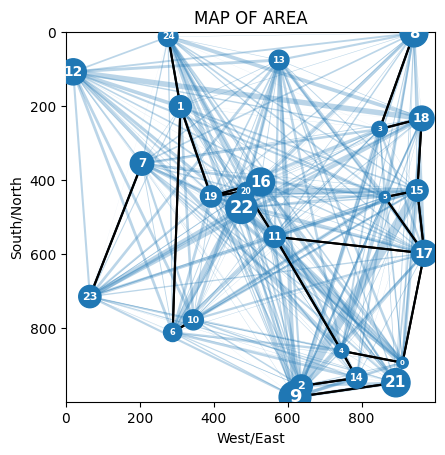

GENERATION #5
Average Fitness: 27989.326290648325
Average Flow Score: 4938.228043135732
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


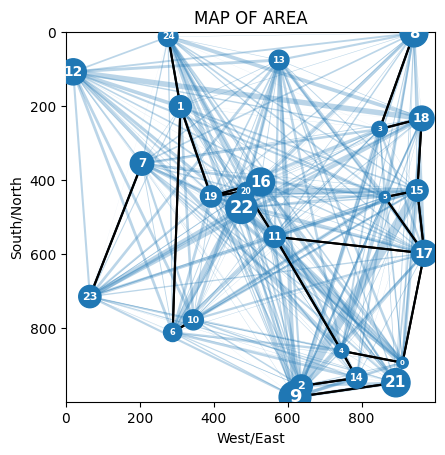

GENERATION #6
Average Fitness: 28857.710965354563
Average Flow Score: 4481.676368226363
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


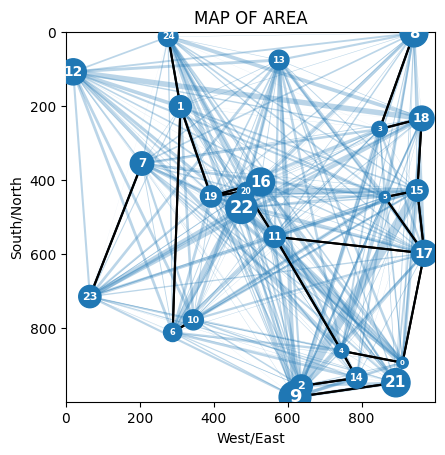

GENERATION #7
Average Fitness: 30028.91353396993
Average Flow Score: 4214.8759743749015
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


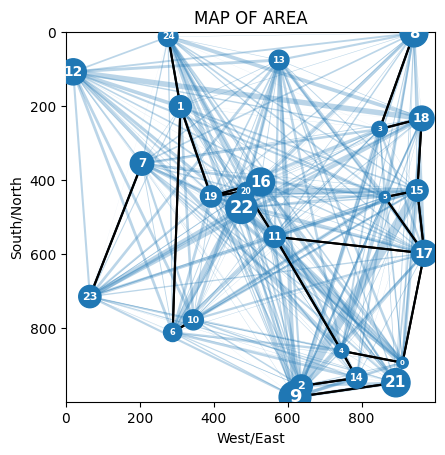

GENERATION #8
Average Fitness: 31269.829838812173
Average Flow Score: 3887.4820120247673
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


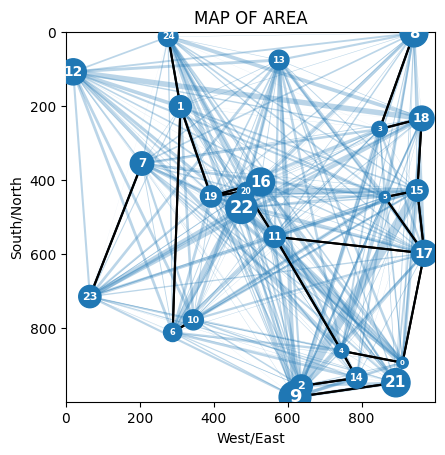

GENERATION #9
Average Fitness: 32099.929552169357
Average Flow Score: 3737.390307769893
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


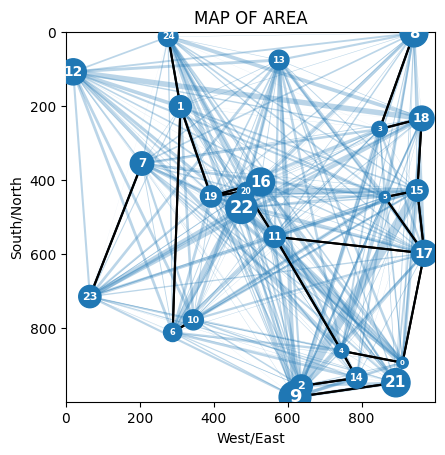

GENERATION #10
Average Fitness: 32136.114464706323
Average Flow Score: 3701.7532053039704
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


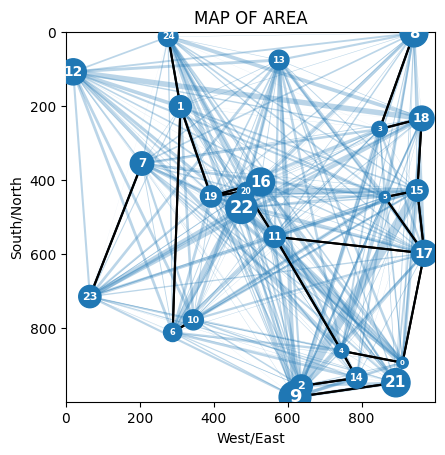

GENERATION #11
Average Fitness: 31613.038949450027
Average Flow Score: 3713.8987365542835
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


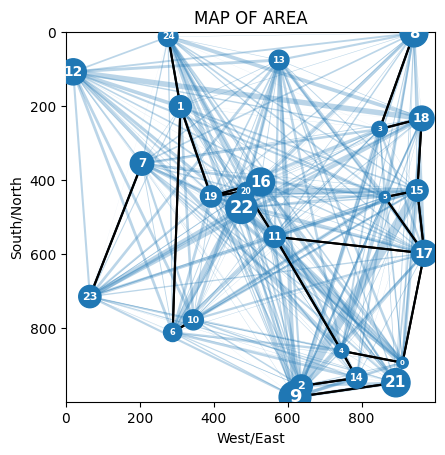

GENERATION #12
Average Fitness: 30381.220604967126
Average Flow Score: 3741.289222987315
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


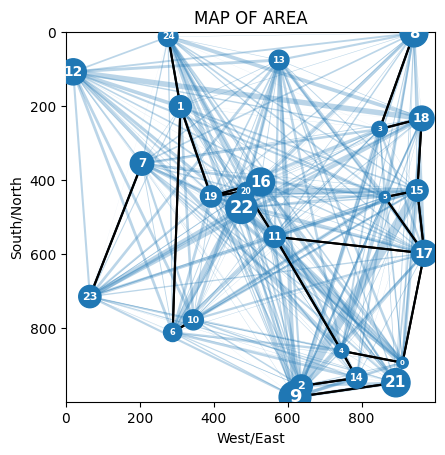

GENERATION #13
Average Fitness: 31715.977244635462
Average Flow Score: 3830.5919821628636
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


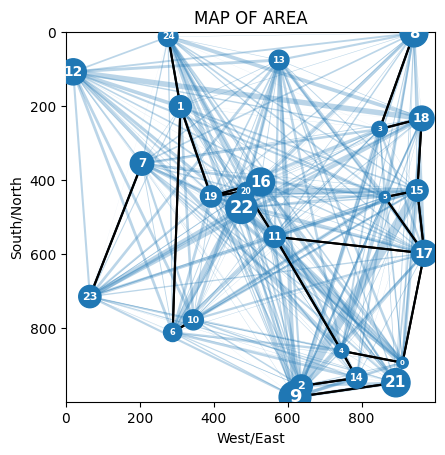

GENERATION #14
Average Fitness: 31354.460941407215
Average Flow Score: 3682.816053341549
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


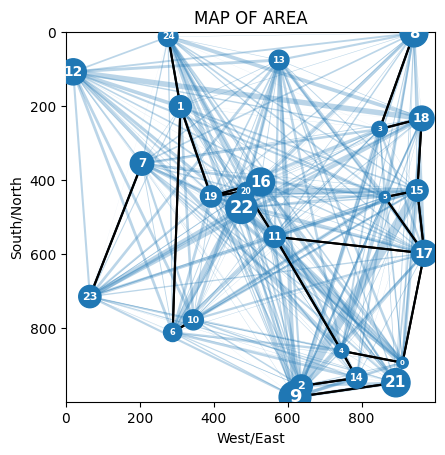

GENERATION #15
Average Fitness: 31762.236334782327
Average Flow Score: 3624.6503759227635
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


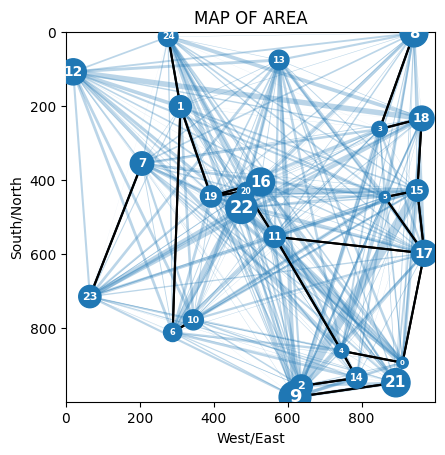

GENERATION #16
Average Fitness: 33624.17614116373
Average Flow Score: 3483.1046963163953
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


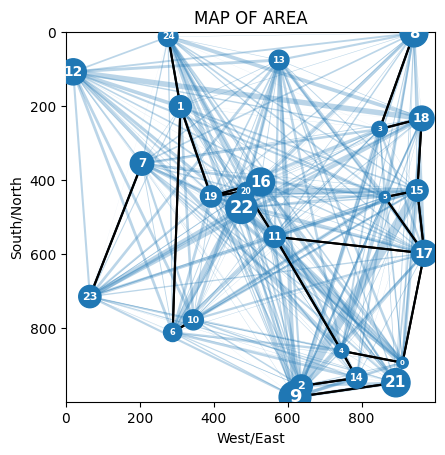

GENERATION #17
Average Fitness: 33487.06233830576
Average Flow Score: 3457.123599457716
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


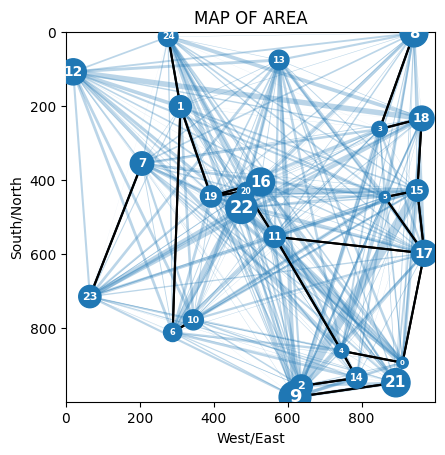

GENERATION #18
Average Fitness: 32773.18154415699
Average Flow Score: 3508.537594302688
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


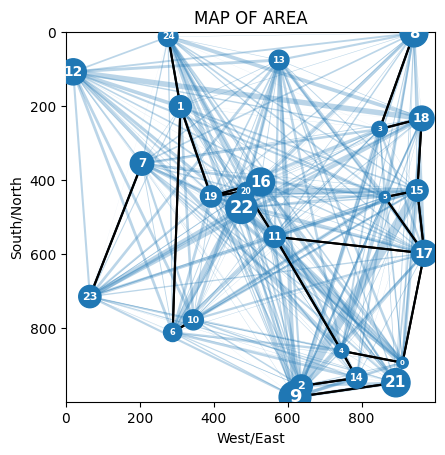

GENERATION #19
Average Fitness: 34006.37030178365
Average Flow Score: 3424.993657610108
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 3642.926705235922
FULL TRACK: 167333.2782569403


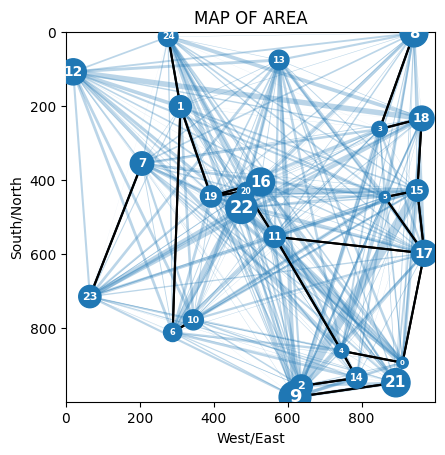

GENERATION #20
Average Fitness: 33409.05876080657
Average Flow Score: 3421.933354782934
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4412.985552509847
FULL TRACK: 167333.2782569403


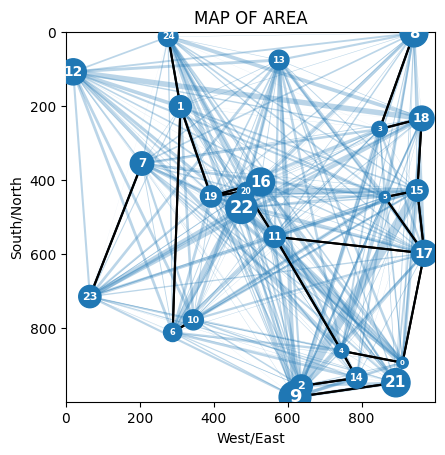

GENERATION #21
Average Fitness: 33716.52723919298
Average Flow Score: 3226.403212574578
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


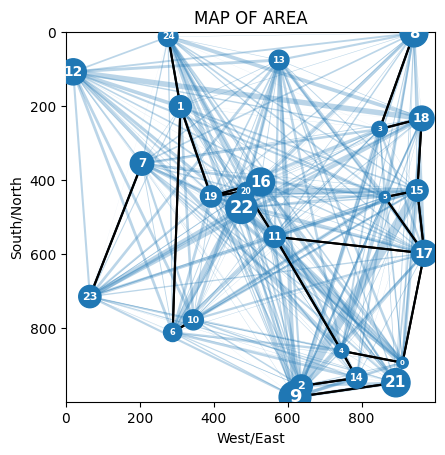

GENERATION #22
Average Fitness: 32531.868691817355
Average Flow Score: 3058.1725857576716
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


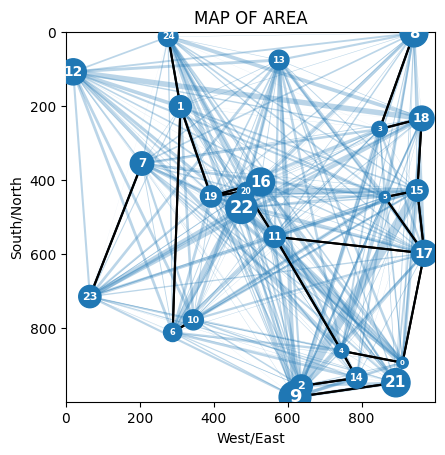

GENERATION #23
Average Fitness: 31900.669587592467
Average Flow Score: 3336.1616596758563
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


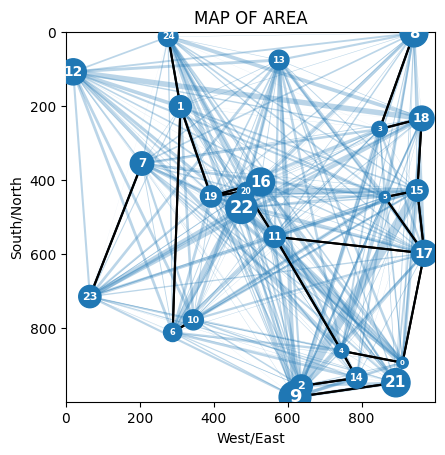

GENERATION #24
Average Fitness: 32428.39524886139
Average Flow Score: 3014.637957846926
BEST FITNESS: 11396.457057855285
FLOW SCORE: 6552.591818680465
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


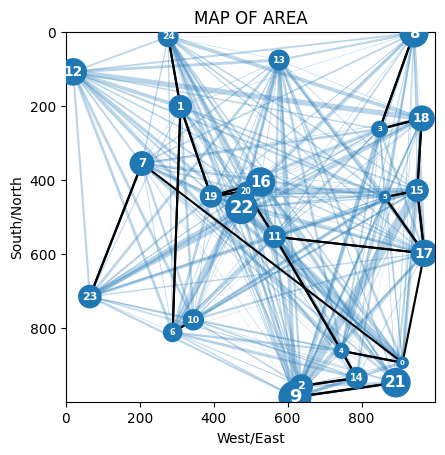

GENERATION #25
Average Fitness: 32993.81111753678
Average Flow Score: 2886.8536497743653
BEST FITNESS: 11001.292982263902
FLOW SCORE: 5269.989857938802
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


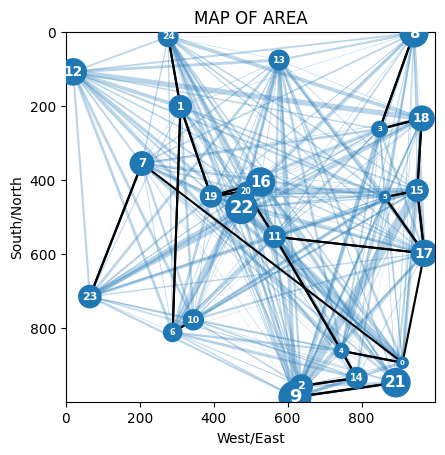

GENERATION #26
Average Fitness: 33838.57989172137
Average Flow Score: 2608.8074051043714
BEST FITNESS: 11001.292982263902
FLOW SCORE: 5269.989857938802
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


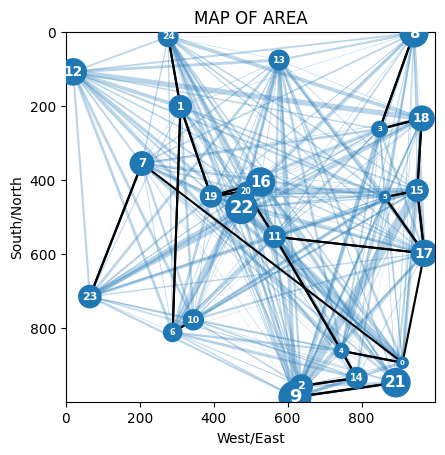

GENERATION #27
Average Fitness: 32846.14780985841
Average Flow Score: 2798.2360354694324
BEST FITNESS: 11001.292982263902
FLOW SCORE: 5269.989857938802
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


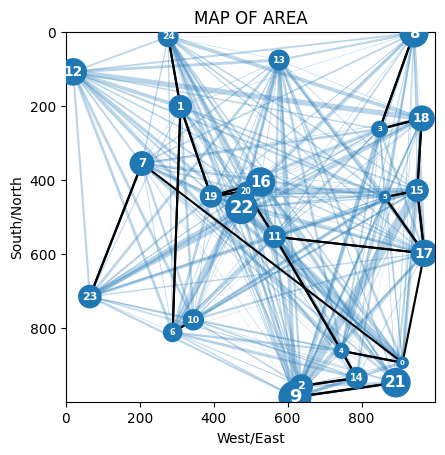

GENERATION #28
Average Fitness: 33395.09172886189
Average Flow Score: 2742.1330123416137
BEST FITNESS: 11001.292982263902
FLOW SCORE: 5269.989857938802
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


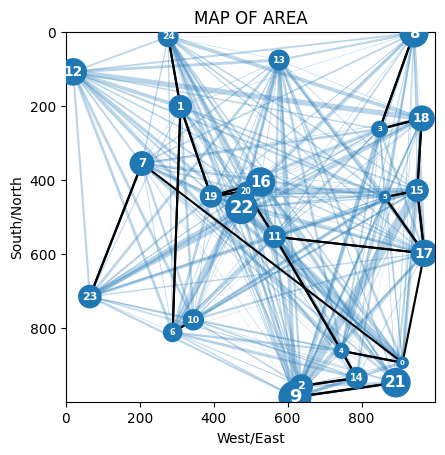

GENERATION #29
Average Fitness: 33480.53129545924
Average Flow Score: 2832.9238557822264
BEST FITNESS: 11001.292982263902
FLOW SCORE: 5269.989857938802
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


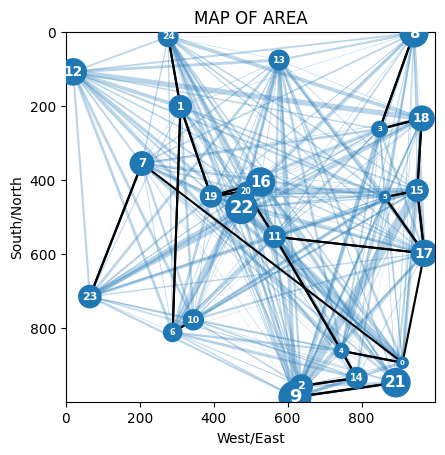

GENERATION #30
Average Fitness: 33145.82609911892
Average Flow Score: 2717.2948857877886
BEST FITNESS: 11001.292982263902
FLOW SCORE: 5269.989857938802
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


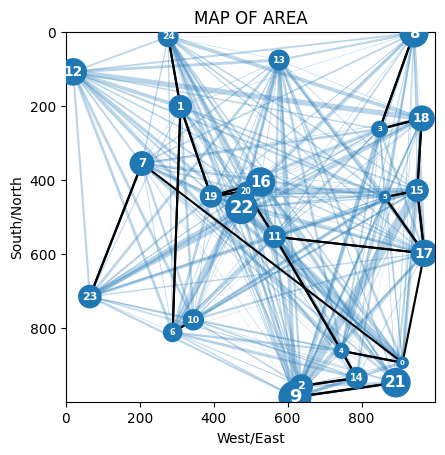

GENERATION #31
Average Fitness: 31457.87448115304
Average Flow Score: 2967.8039085522814
BEST FITNESS: 11001.292982263902
FLOW SCORE: 5269.989857938802
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


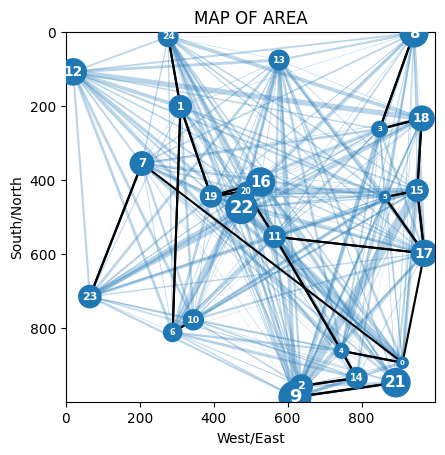

GENERATION #32
Average Fitness: 32804.828656885846
Average Flow Score: 2871.0131492441105
BEST FITNESS: 11001.292982263902
FLOW SCORE: 5269.989857938802
FLOW SCORE TO BEAT: 509.96040772055136
TRACK LENGTH: 4843.86523917482
FULL TRACK: 167333.2782569403


KeyboardInterrupt: ignored

In [ ]:
for gen in range(NUM_GENERATIONS):
  # Evaluate population
  best_idx, best_fit_flow_score, best_fit_score, best_track_len, best_line, avg_flow_score, avg_fit_score, FLOW_SCORES, FITNESS_SCORES = evaluate(LINES_POP)

  # Display results
  plot_system(CANVAS, best_line)
  print(f'\033[1mGENERATION #{gen}\033[0m')
  print(f'Average Fitness: {avg_fit_score}')
  print(f'Average Flow Score: {avg_flow_score}')
  print(f'BEST FITNESS: {best_fit_score}')
  print(f'FLOW SCORE: {best_fit_flow_score}')
  print(f'FLOW SCORE TO BEAT: {BEST_SCORE}')
  print(f'TRACK LENGTH: {best_track_len}')
  print(f'FULL TRACK: {FULL_TRACK}')

  # Selection (parents and elites)
  parent_idxs, mutated_idxs, elite_idxs = selection(FITNESS_SCORES)
  parents = LINES_POP[parent_idxs]
  mutants = LINES_POP[mutated_idxs]
  elites = LINES_POP[elite_idxs]

  # Crossover
  children = crossover(parents)

  # Mutation
  mutated = mutation(mutants)

  # Next gen
  del LINES_POP
  LINES_POP = np.concatenate((children, mutants), axis=0)
  LINES_POP = np.concatenate((LINES_POP, elites), axis=0)